In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from IPython.display import clear_output
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoConfig, BertTokenizerFast, BertForSequenceClassification, DataCollatorWithPadding, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

MODEL_NAME = "google-bert/bert-base-uncased"

cuda


In [36]:
df = pd.read_csv(
    "/kaggle/input/video-games/Video_Games_5_part0.csv",
    on_bad_lines="skip"
)
df = df.dropna(subset=["reviewText", "overall"])

class_counts = df['overall'].value_counts()
print(f"Распределение классов:\n{class_counts}")

Распределение классов:
overall
5.0    284435
4.0     88407
3.0     46546
1.0     29138
2.0     22830
Name: count, dtype: int64


In [37]:
X = df["reviewText"].astype(str)
y = df["overall"].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15 / 0.85,
    random_state=42,
    stratify=y_temp
)
print("Done")

Done


#Fine-Tuning BERT

###1) Dataset+токенизация

In [38]:
class ReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = list(texts)
        self.labels = list(labels) if labels is not None else None
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            padding=False,
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}

        if self.labels is not None:
            label = int(self.labels[idx]) - 1
            item["labels"] = torch.tensor(label, dtype=torch.long)

        return item


tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
train_ds = ReviewsDataset(X_train, y_train, tokenizer, max_length=256)
val_ds   = ReviewsDataset(X_val,   y_val,   tokenizer, max_length=256)
test_ds  = ReviewsDataset(X_test,  y_test,  tokenizer, max_length=256)
print("Done")

Done


###2) DataLoader

In [39]:
BATCH_SIZE = 32
persistent_workers=True

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
    collate_fn=data_collator
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator
)
print("Done")

Done


###3) Загрузка Bert

In [40]:
import os

epoch = 0
p = 0.1

if epoch == 0:
    config = AutoConfig.from_pretrained(MODEL_NAME)

    config.num_labels = 5
    config.problem_type = "single_label_classification"
    config.hidden_dropout_prob = p
    config.attention_probs_dropout_prob = p
    config.classifier_dropout = p
    
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

else:
    ckpt_dir = f"/kaggle/working/bert_rating_ckpt_epoch{epoch}"
    if not os.path.isdir(ckpt_dir):
        raise FileNotFoundError(f"Не нашёл папку чекпойнта: {ckpt_dir}")

    config = AutoConfig.from_pretrained(ckpt_dir)
    config.hidden_dropout_prob = p
    config.attention_probs_dropout_prob = p
    config.classifier_dropout = p

    model = BertForSequenceClassification.from_pretrained(ckpt_dir, config=config)

model = model.to(device)
print(model)

С какой эпохи грузиться? (0 = старт с pretrained, иначе номер чекпойнта):  0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

###4) Гиперпараметры + Шедулер

In [41]:
# Гиперпараметры
lr = 2e-5
weight_decay = 0.01
epochs = 1
warmup_ratio = 0.1
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(warmup_ratio * num_training_steps)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print("Done")

Done


###5) Код для эпохи

In [42]:
def run_epoch(
    model, dataloader, device, train: bool,
    optimizer=None, scheduler=None,
    max_grad_norm: float = 1.0,
    desc="Train",
    plot_live=False,
    plot_every=100,
    min_plot_interval_sec=1.0
):
    if train:
        assert optimizer is not None, "optimizer обязателен при train=True"
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total_count = 0.0, 0, 0
    win_loss, win_correct, win_count = 0.0, 0, 0

    pbar = tqdm(dataloader, desc=desc, leave=False)

    steps, loss_hist, acc_hist = [], [], []
    last_plot_t = 0.0

    grad_ctx = torch.enable_grad() if train else torch.no_grad()
    with grad_ctx:
        for step, batch in enumerate(pbar, start=1):
            batch = {k: v.to(device) for k, v in batch.items()}

            if train:
                optimizer.zero_grad(set_to_none=True)

            outputs = model(**batch)
            loss, logits = outputs.loss, outputs.logits

            bs = logits.size(0)
            preds = logits.argmax(dim=-1)
            correct = (preds == batch["labels"]).sum().item()

            total_loss += loss.item() * bs
            total_correct += correct
            total_count += bs

            win_loss += loss.item() * bs
            win_correct += correct
            win_count += bs

            if train:
                loss.backward()
                clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

            cur_loss = total_loss / total_count
            cur_acc = total_correct / total_count
            pbar.set_postfix(loss=f"{cur_loss:.4f}", acc=f"{cur_acc:.4f}", refresh=False)

            if plot_live and (step % plot_every == 0) and win_count > 0:
                now = time.time()
                if now - last_plot_t >= min_plot_interval_sec:
                    last_plot_t = now

                    window_loss = win_loss / win_count
                    window_acc = win_correct / win_count

                    steps.append(step)
                    loss_hist.append(window_loss)
                    acc_hist.append(window_acc)

                    win_loss, win_correct, win_count = 0.0, 0, 0

                    clear_output(wait=True)
                    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

                    ax[0].plot(steps, loss_hist, marker="o", linewidth=1.5)
                    ax[0].set_title(f"{desc}: loss (last {plot_every} batches)")
                    ax[0].set_xlabel("Batch")
                    ax[0].grid(True)

                    ax[1].plot(steps, acc_hist, marker="o", linewidth=1.5)
                    ax[1].set_title(f"{desc}: acc (last {plot_every} batches)")
                    ax[1].set_xlabel("Batch")
                    ax[1].grid(True)

                    plt.show()

    return total_loss / total_count, total_correct / total_count

###6) Тренировка 10310 батчей

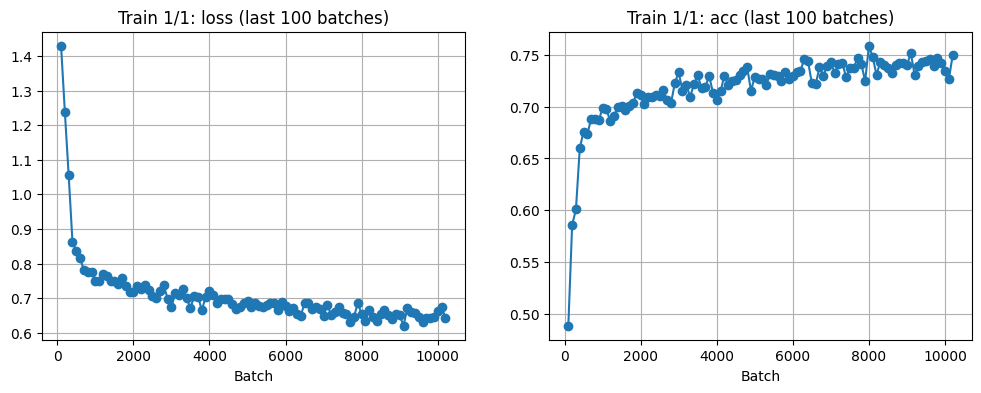

In [ ]:
epoch += 1
train_loss, train_acc = run_epoch(
    model, train_loader, device,
    train=True, optimizer=optimizer, scheduler=scheduler,
    desc=f"Train {epoch}/{epochs}",
    plot_live=True, plot_every=100
)

val_loss, val_acc = run_epoch(
  model, val_loader, device,
  train=False,
  desc=f"Val {epoch}/{epochs}"
)

print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

save_dir = f"/kaggle/working/bert_rating_ckpt_epoch{epoch}"
os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("Saved to:", save_dir)

Epoch 1: train_loss=0.7085 train_acc=0.7195 | val_loss=0.6459 val_acc=0.7424

###7) Оценка модели

In [ ]:

def predict_on_loader(model, dataloader, device, desc="Test"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)

            y_true.append(batch["labels"].cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

y_true, y_pred = predict_on_loader(model, val_loader, device, desc="Test")

print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
mae_torch = (torch.as_tensor(y_true) - torch.as_tensor(y_pred)).abs().float().mean().item()
print("MAE:", mae_torch)

    precision    recall  f1-score   support
0     0.6714    0.7186    0.6942      4371
1     0.4645    0.3206    0.3793      3425
2     0.5231    0.4841    0.5029      6982
3     0.5584    0.3782    0.4509     13261
4     0.8265    0.9341    0.8770     42665
accuracy                         0.7424     70704
macro avg     0.6088    0.5671    0.5809     70704
weighted avg     0.7192    0.7424    0.7248     70704
Confusion matrix:
[[ 3141   562   356    43   269]
[  883  1098  1081   138   225]
[  385   603  3380  1490  1124]
[  112    78  1309  5015  6747]
[  157    23   335  2295 39855]]
MAE: 0.3212689459323883